In [1]:
!pip install gym[atari]

In [2]:
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

In [3]:
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1
!pip install gym[atari] > /dev/null 2>&1

Requirement already up-to-date: setuptools in /usr/local/lib/python3.6/dist-packages (47.3.1)


In [4]:
import numpy as np
import gym
from gym import spaces
import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display as ipythondisplay

from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(40) #error only

import math
import random
import glob
import io
import base64
from IPython.display import HTML
from collections import deque

from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras import initializers
from keras.optimizers import Adam, RMSprop
from keras import backend as K

Using TensorFlow backend.


#Testing Environment

In [5]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(400, 300))
display.start()

In [6]:
"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    

def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

In [7]:
#TESTING ENVIRONMENT

ENV_NAME = 'CartPole-v0'
env = wrap_env(gym.make(ENV_NAME))
state = env.reset()
print("Observation space:", env.observation_space.shape[0], env.observation_space.shape)
print ("state: ", state.shape, state)
tmp = np.reshape(state, (1, 4))
print (tmp.shape, tmp)
print("Action space:", env.action_space)

def test_Agent(env):
  env.reset()
  reward1 = 0
  done = False
  steps = 0
  while not done:
      env.render()
      action = env.action_space.sample()      
      observation, reward, done, _ = env.step(action) 
      reward1 += reward
      steps += 1
  env.close()
  show_video()
  return reward1, steps


r, s = test_Agent(env)
print (f'Reward before training: {r}')
print (f'Max_steps: {s}')

Observation space: 4 (4,)
state:  (4,) [ 0.04436266  0.02317204 -0.01418755 -0.0404737 ]
(1, 4) [[ 0.04436266  0.02317204 -0.01418755 -0.0404737 ]]
Action space: Discrete(2)


Reward before training: 37.0
Max_steps: 37


In [30]:
def model(input_shape, num_classes):
  weights = initializers.RandomNormal(stddev=0.01)
  adv = Input(shape=(1, ))
  input = Input(shape=input_shape)
  X = Dense(32, kernel_initializer=weights, activation='relu')(input)
  X = Dense(64, kernel_initializer=weights,activation='relu')(X)
  X = Dense(64, kernel_initializer=weights,activation='relu')(X)  
  output1 = Dense(num_classes,  kernel_initializer=weights, activation='softmax')(X)
  
  def customLoss(yTrue,yPred):
    log = yTrue * K.log(yPred)
    return K.sum(-log * adv)

  policy_model = Model(input=[input, adv], output=[output1])
  policy_model.compile(optimizer=Adam(lr=0.001), loss=customLoss, metrics=['accuracy'])
  output2 = Model(input=[input], output=[output1])  
  
  return policy_model, output2  

class Reinforce(object):
  def __init__(self, env, gamma):
    self.env = env
    self.observation_space = env.observation_space
    self.action_space = env.action_space
    self.actions = [i for i in range(self.action_space.n)]
    self.policy_model, self.prob_model = model(input_shape=(self.observation_space.shape[0],), num_classes=self.action_space.n)
    self.gamma = gamma
  
  def discount_reward_and_update(self, reward_memory):
    discounted_reward_memory = np.zeros_like(reward_memory)
    G_sum = 0
    for index, reward1 in reversed(list(enumerate(reward_memory))):
      G_sum =  (G_sum * self.gamma) + reward1
      discounted_reward_memory[index] = G_sum
    return discounted_reward_memory 

    


In [31]:
def train_agent(env, agent):
  total_rewards = []
  average_rewards = deque(maxlen=100)
  for episode in range(EPISODES):
    state = env.reset()
    state_memory, action_memory, reward_memory = [],[],[]
    done, current_rewards, timestep = False, 0, 0
    while not done:
      action_prob = agent.prob_model.predict(state[np.newaxis, :])[0]
      action = np.random.choice(agent.actions, p=action_prob)
      next_state, reward, done, _ = env.step(action)
      state_memory.append(state)
      reward_memory.append(reward)
      action1 = np.zeros((env.action_space.n, ))
      action1[action] = 1
      #print (action1)
      action_memory.append(action1)
      current_rewards += reward
      #print (current_rewards)
      state = next_state

    advantages = agent.discount_reward_and_update(reward_memory) 
    cost = agent.policy_model.train_on_batch([np.array(state_memory), advantages], np.array(action_memory))
    #print (cost)
    total_rewards.append(current_rewards)
    average_rewards.append(current_rewards)
    
    print(f'Episode: {episode}, Reward: {current_rewards}', end = ' ')
    if (len(average_rewards) == 100):
      print (f'Average Reward = {np.mean(average_rewards)}')
    else:
      print(end='\n')

  return agent, total_rewards

def test1(env, agent):
  state = env.reset()
  done = False
  current_reward = 0
  while not done:
    env.render()
    action_prob = agent.prob_model.predict(state[np.newaxis, :])[0]
    #print (action_prob)
    action = np.random.choice(agent.actions, p=action_prob)

    next_state, reward, done, _ = env.step(action)
    state = next_state.copy()
    current_reward += 1

  print(f'Reward: {current_reward}')
  env.close()
  show_video()

In [32]:
GAMMA = 0.99
EPISODES = 800

In [33]:
env1 = gym.make('CartPole-v0')
agent = Reinforce(env1, GAMMA)

#Train
agent, total_rewards  = train_agent(env1, agent)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=[<tf.Tenso...)`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=[<tf.Tenso...)`
  app.launch_new_instance()


Episode: 0, Reward: 10.0 
Episode: 1, Reward: 14.0 
Episode: 2, Reward: 35.0 
Episode: 3, Reward: 30.0 
Episode: 4, Reward: 15.0 
Episode: 5, Reward: 10.0 
Episode: 6, Reward: 16.0 
Episode: 7, Reward: 12.0 
Episode: 8, Reward: 27.0 
Episode: 9, Reward: 18.0 
Episode: 10, Reward: 12.0 
Episode: 11, Reward: 17.0 
Episode: 12, Reward: 54.0 
Episode: 13, Reward: 12.0 
Episode: 14, Reward: 47.0 
Episode: 15, Reward: 26.0 
Episode: 16, Reward: 17.0 
Episode: 17, Reward: 43.0 
Episode: 18, Reward: 13.0 
Episode: 19, Reward: 37.0 
Episode: 20, Reward: 20.0 
Episode: 21, Reward: 10.0 
Episode: 22, Reward: 22.0 
Episode: 23, Reward: 27.0 
Episode: 24, Reward: 9.0 
Episode: 25, Reward: 23.0 
Episode: 26, Reward: 20.0 
Episode: 27, Reward: 17.0 
Episode: 28, Reward: 20.0 
Episode: 29, Reward: 20.0 
Episode: 30, Reward: 19.0 
Episode: 31, Reward: 15.0 
Episode: 32, Reward: 22.0 
Episode: 33, Reward: 23.0 
Episode: 34, Reward: 13.0 
Episode: 35, Reward: 17.0 
Episode: 36, Reward: 22.0 
Episode: 37,

In [34]:
#Test
env2 = wrap_env(gym.make('CartPole-v0'))
test1(env2, agent)

Reward: 190


In [35]:
def plotRewards(total_rewards):
  plt.plot(total_rewards)
  plt.xlabel('Episode')
  plt.ylabel('Total Reward (per episode)')
  plt.show()

def plotAverageReward(total_rewards):
  plt.xlabel('Episode')
  plt.ylabel('Total Reward (Average reward in 10 episodes)')
  plt.plot([np.mean(total_rewards[tr:tr+10]) for tr in range(10, len(total_rewards))])
  plt.show()

def plotAverageReward100(total_rewards):
  plt.xlabel('Episode')
  plt.ylabel('Total Reward (Average reward in 100 episodes)')
  plt.plot([np.mean(total_rewards[tr:tr+100]) for tr in range(100, len(total_rewards))])
  plt.show()

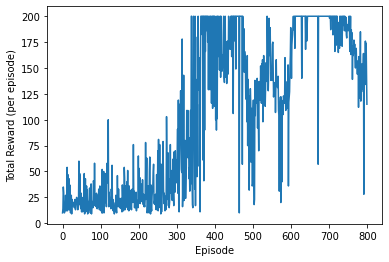

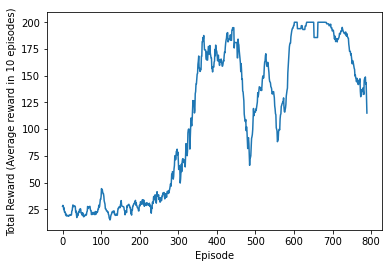

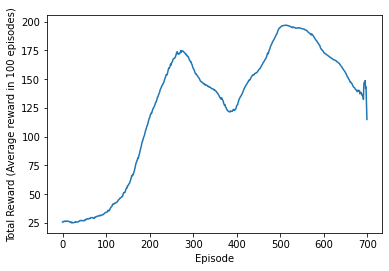

In [36]:
plotRewards(total_rewards)
plotAverageReward(total_rewards)
plotAverageReward100(total_rewards)